# Retrieval Demo in SSL Embedding Space (SimCLR on STL-10)

Goal: demonstrate that SSL embeddings support similarity search.
We load precomputed embeddings (from the UMAP notebook), run cosine top-k retrieval,
and visualize the query image with its nearest neighbors.

This notebook is GPU-light: retrieval is done on saved embedings.


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
METRICS_DIR = ARTIFACTS_DIR / "metrics"
EMB_DIR = ARTIFACTS_DIR / "embeddings"
FIG_DIR = ARTIFACTS_DIR / "figures"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("EMB_DIR:", EMB_DIR)

PROJECT_ROOT: D:\ML\SSL
EMB_DIR: D:\ML\SSL\artifacts\embeddings


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data.stl10_datamodule import STL10DataModule
from src.utils.seed import set_seed
from src.utils.embeddings import load_embeddings_npz
from src.utils.retrieval import cosine_topk, batch_cosine_topk, mean_class_hit_at_k

set_seed(42)

In [3]:
runs_df = pd.read_csv(METRICS_DIR / "runs_index.csv")
assert not runs_df.empty

run = runs_df.iloc[-1].to_dict()
run_id = run["run_id"]
method = run["method"]

emb_path = EMB_DIR / f"{run_id}_eval_train.npz"
print("Loading:", emb_path)

pack, meta = load_embeddings_npz(emb_path)
Z = pack.z
y = pack.y.astype(int)

print("Embeddings:", Z.shape, "Labels:", y.shape)
print("Meta:", meta)

Loading: D:\ML\SSL\artifacts\embeddings\simclr_version_0_eval_train.npz
Embeddings: (5000, 512) Labels: (5000,)
Meta: {'run_id': 'simclr_version_0', 'method': 'simclr', 'split': 'eval_train'}


In [4]:
# Get the original labeled dataset to visualize images

dm = STL10DataModule(
    data_dir=str(PROJECT_ROOT / "data"),
    batch_size=256,
    num_workers=4,
    image_size=96,
    pin_memory=True,
)
dm.prepare_data()
dm.setup()

ds = dm.eval_train
assert len(ds) == Z.shape[0], "Dataset size and embeddings size mismatch"
len(ds)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


5000

In [5]:
# Helper to show query + neighbors grid

def show_retrieval_grid(ds, res, k=10, title=None):
    # ds[i] -> (image_tensor, label)
    idxs = [res.query_index] + res.neighbors[:k].tolist()
    imgs = []
    labels = []
    for i in idxs:
        x, lab = ds[i]
        # x: Tensor CHW in [0,1] (EvalTransforms). Convert to HWC for matplotlib.
        img = x.permute(1, 2, 0).cpu().numpy()
        imgs.append(img)
        labels.append(int(lab))

    cols = min(k + 1, 6)
    rows = int(np.ceil((k + 1) / cols))

    plt.figure(figsize=(cols * 3, rows * 3))
    for j, (img, lab) in enumerate(zip(imgs, labels)):
        ax = plt.subplot(rows, cols, j + 1)
        ax.imshow(img)
        ax.axis("off")
        if j == 0:
            ax.set_title(f"QUERY\nlabel={lab}", fontsize=10)
        else:
            score = float(res.scores[j - 1])
            ax.set_title(f"#{j}\nlabel={lab}\ncos={score:.3f}", fontsize=9)

    if title:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1831644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.167882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7139517..2.1256242].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5503755..1.4190241].


Query label: 1
Neighbor labels: [1, 1, 7, 1, 1, 7, 3, 3, 7, 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7139517..1.9448375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6859657..2.1373162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8121624..1.8316599].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4698005..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..1.9844881].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6407689..1.2050649].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.716096

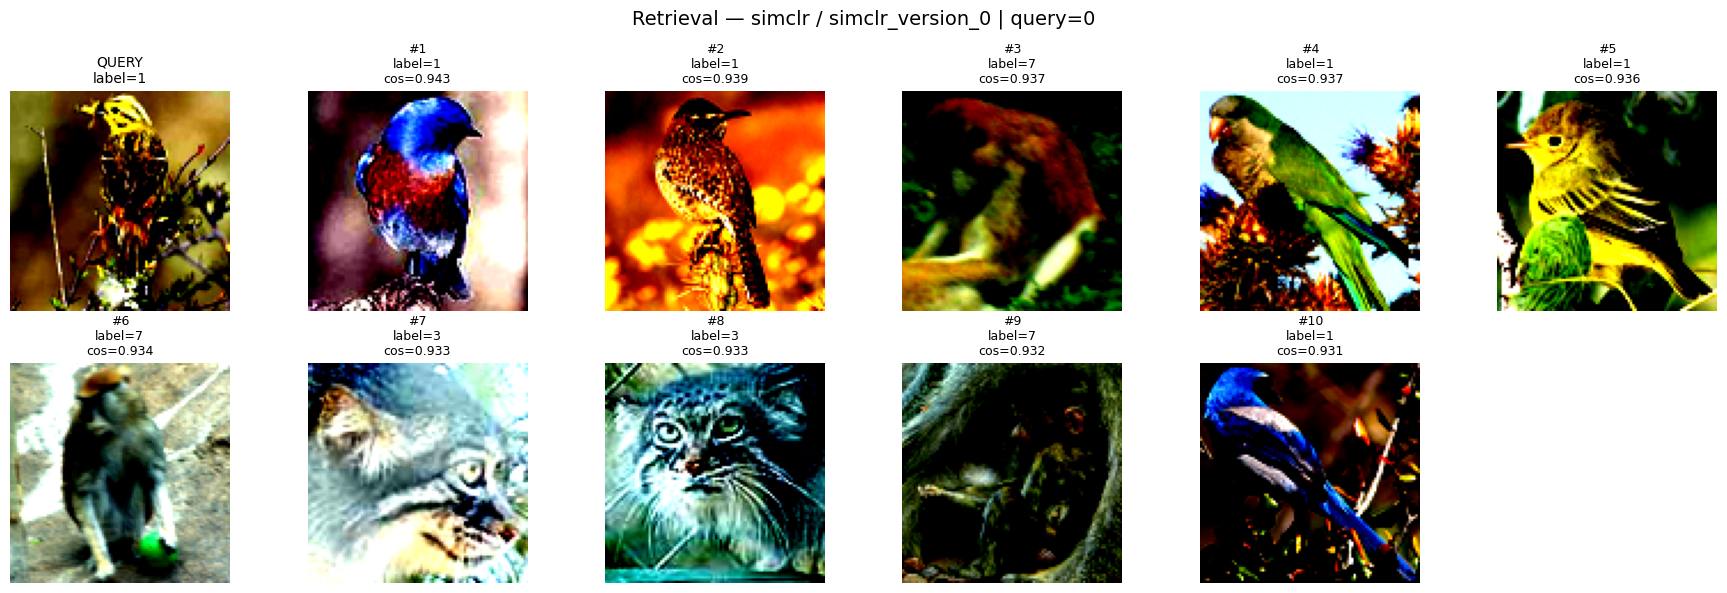

In [6]:
# Single query demo

query_idx = 0  # попробуй 0, 10, 123, random ниже
res = cosine_topk(Z, query_idx=query_idx, k=10, exclude_self=True, y=y)
print("Query label:", res.query_label)
print("Neighbor labels:", res.neighbor_labels.tolist())
show_retrieval_grid(ds, res, k=10, title=f"Retrieval — {method} / {run_id} | query={query_idx}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5764065..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1105585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..1.5983292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1831644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1831644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6558344..2.1256242].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.713951

Mean class Hit@10 (qualitative): 0.9166666666666666


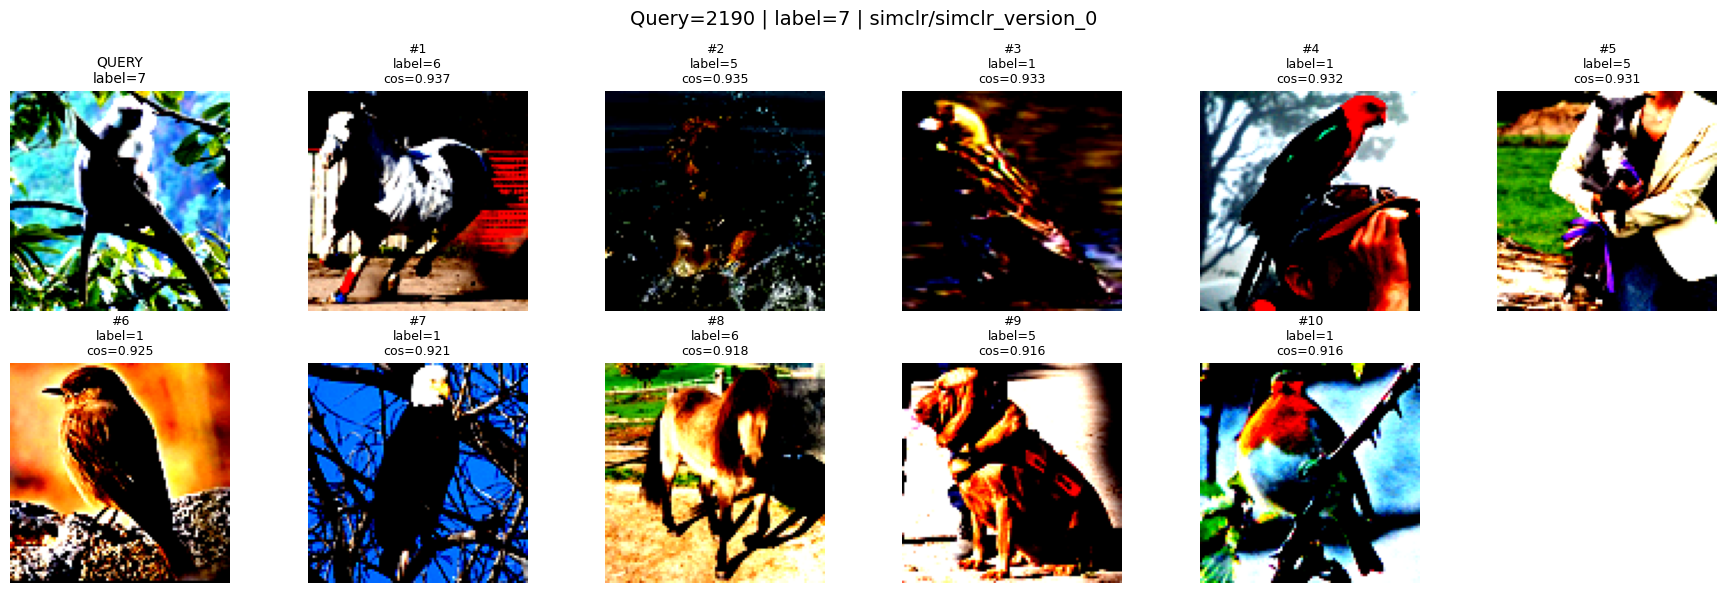

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..1.8775084].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.716096

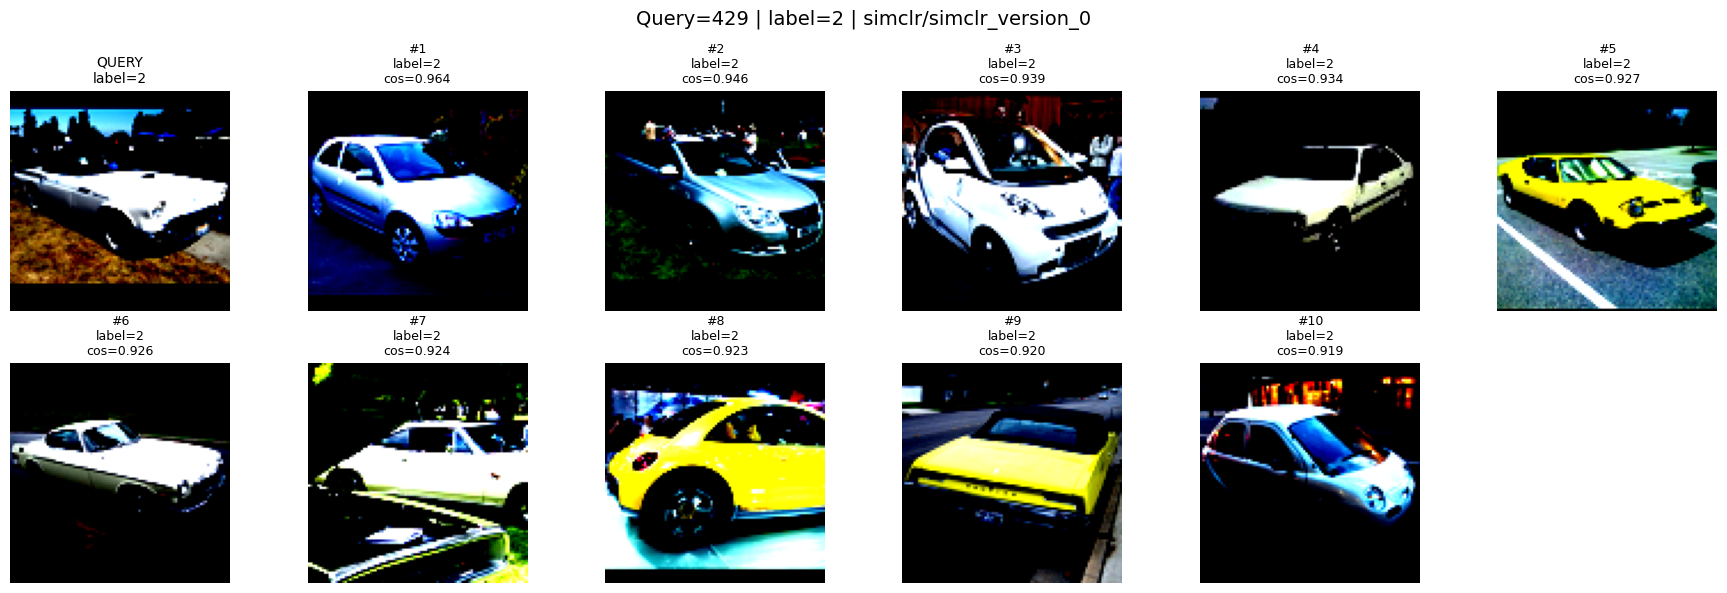

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4698005..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2791952..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3997197..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.530558..2.1256242].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4388611..0.85741144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.550375

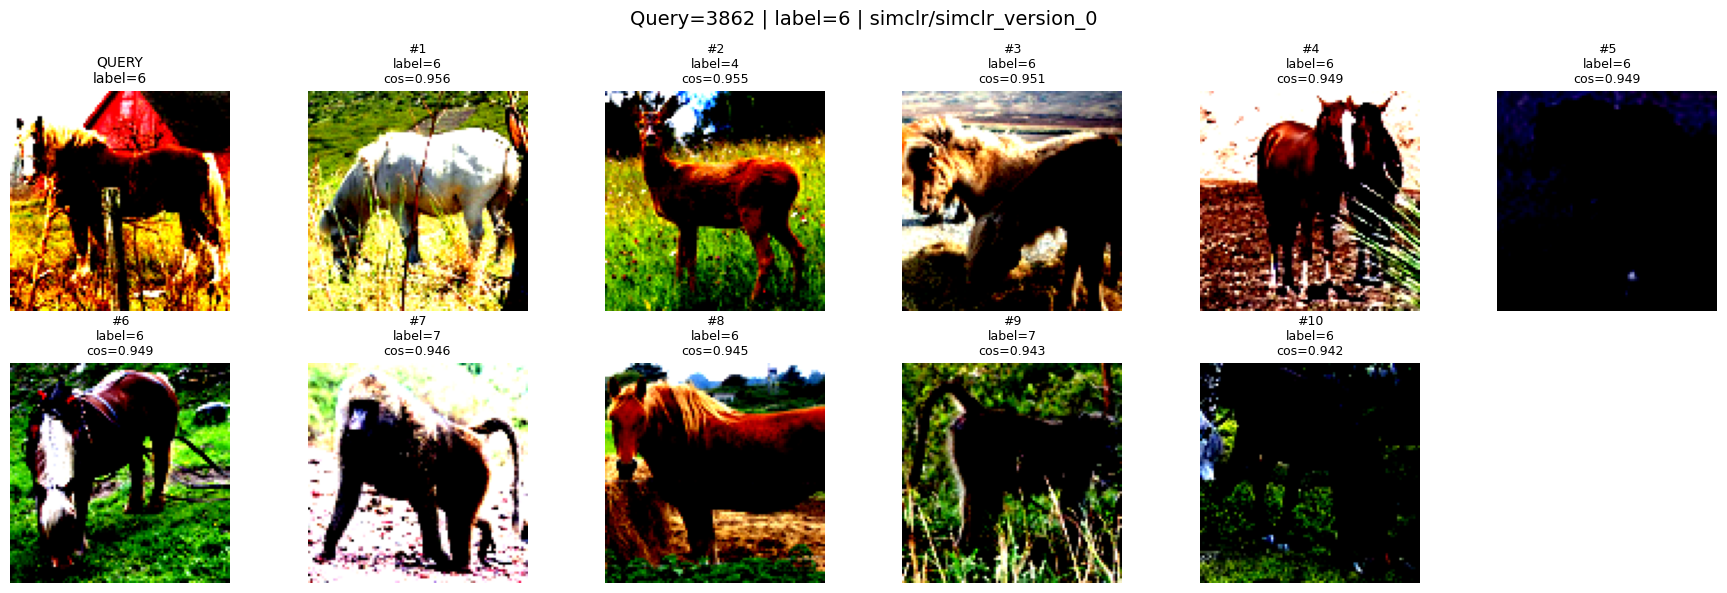

In [7]:
# Random queries + quick “hit@k” sanity metric

rng = np.random.default_rng(42)
queries = rng.choice(len(ds), size=12, replace=False).tolist()

results = batch_cosine_topk(Z, query_indices=queries, k=10, exclude_self=True, y=y)
hit10 = mean_class_hit_at_k(results, k=10)
print("Mean class Hit@10 (qualitative):", hit10)

# show a couple examples
for qi, r in zip(queries[:3], results[:3]):
    show_retrieval_grid(ds, r, k=10, title=f"Query={qi} | label={r.query_label} | {method}/{run_id}")

## Conclusions

In this notebook we demonstrated **image retrieval** in the learned SSL embedding space.

### What was done
- Loaded precomputed embeddings for the **STL-10 labeled train split** (computed with a frozen SimCLR encoder).
- Performed **cosine similarity** search to retrieve top-k nearest neighbors for a given query image.
- Visualized the query image together with its nearest neighbors.
- Added a lightweight qualitative sanity metric: **Mean class Hit@10** over random queries.

### Observations
- Nearest neighbors are often visually and semantically similar to the query.
- Even after a lightweight training run, SSL embeddings already support meaningful similarity search.
- Retrieval results are not perfect (some neighbors belong to other classes), which is expected given the short training regime.

### Limitations
- This is a **qualitative** demo (retrieval + simple Hit@10), not a strict benchmark.
- Retrieval was performed on the train split only and without a dedicated ANN index (FAISS is optional).

### Next steps
- Add **kNN evaluation** and **linear probe** as quantitative checks of representation quality.
- Optionally add **FAISS indexing** for faster retrieval on larger embedding sets.
- (Later) compare retrieval quality between **SimCLR vs BYOL**.
